### 古典MD (GAFF2/AM1BCC力場）の実行とQEファイルの出力  
Benzene 8分子(96原子)を25℃ (密度0.874)でNVTでMD計算    
ベンゼン密度：https://www.chemicalbook.com/ChemicalProductProperty_EN_CB6854153.htm   
1ナノ秒をdt = 0.2 fsで計算する。   
MDのカットオフ半径は4Å　長距離静電相互作用はPMEを使用。    
1fsで構造を出力し、最初の1,001フレームを捨てて4,000構造を出力する。    
ASEで構造を読み込んで、Quantum Espressoフォーマットで出力  

In [17]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools

In [16]:
# ----- System setting -------

num_atoms_per_molecule = 6
num_molecules = 32
max_atoms= num_atoms_per_molecule*num_molecules

# density(g/cm3) from experiment
density = 0.791

dt = 0.2                           #[fs] MDの刻み時間：このまま使うことを推奨。
eq_temp = 25+273.15                #緩和計算させるときの温度 [K]
eq_steps = 25000                   #緩和計算するstep数。この例だと5 psec.
eq_cutoff = 4.8

# !. /opt/gromacs/bin/GMXRC
# gromacs_home = "/opt/homebrew/bin/gmx"
gromacs_home = "/usr/local/bin/gmx"

In [20]:
import shutil
src = './input.acpype/input_GMX.gro'
copy = './input1.gro'
shutil.copyfile(src,copy)
src = './input.acpype/input_GMX.itp'
copy = './input1.itp'
shutil.copyfile(src,copy)

In [21]:
gaff_bcc(smiles_list_polymer[0])


1 molecule converted
1 molecule converted
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2022.6.6 (c) 2022 AWSdS |
==> ... charge set to 0
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
==> * Tleap OK *
==> Removing temporary files...
==> Using OpenBabel v.3.1.0

==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

==> Writing pickle file input.pkl
==> Removing temporary files...
Total time of execution: less than a second


In [22]:
#make mdp file for energy minimization
def make_mdp_em(cutoff):

    mdp_file = "em.mdp"
    cutoff_radius    = cutoff/10.0
    
    lines = [
    "; VARIOUS PREPROCESSING OPTIONS",
    ";title                    = Yo",
    ";cpp                      = /usr/bin/cpp",
    "include                  =", 
    "define                   =", 
    "    ",
    "; RUN CONTROL PARAMETERS",
    "integrator               = steep",
    "nsteps                   = 1000000",
    "emtol                    = 10",
    "emstep                   = 0.1",
    "nstlist                  = 1",
    "cutoff-scheme            = verlet",
    "vdw-type                 = cut-off",
    "rlist                    = {}".format(cutoff_radius),
    "rvdw                     = {}".format(cutoff_radius),
    "rcoulomb                 = {}".format(cutoff_radius),
    ]

    with open(mdp_file, mode='w') as f:
        f.write('\n'.join(lines))

In [23]:
#make mdp file for NVT run
def make_mdp_nvt(temp,steps,dt,cutoff):

    temperature      = temp
    simulation_steps = steps 
    time_step        = dt/1000.0  # ps
    cutoff_radius    = cutoff/10.0
    
    mdp_file = "run.mdp"

    lines = [
    "; VARIOUS PREPROCESSING OPTIONS",
    ";title                    = Yo",
    ";cpp                      = /usr/bin/cpp",
    "include                  =", 
    "define                   =", 
    "    ",
    "; RUN CONTROL PARAMETERS",
    "constraints              = none",
    "integrator               = md",
    "nsteps                   = {}".format(simulation_steps),
    "dt                       = {}".format(time_step),
    "nstlist                  = 1",
    "rlist                    = {}".format(cutoff_radius),
    "rvdw                     = {}".format(cutoff_radius),
    "rcoulomb                 = {}".format(cutoff_radius),
    "coulombtype              = pme",
    "cutoff-scheme            = verlet",
    "vdw-type                 = cut-off",        
    "tc-grps                  = system",
    "tau-t                    = 0.1",
    "gen-vel                  = yes",
    "gen-temp                 = {}".format(temperature),
    "ref-t                    = {}".format(temperature),
    "Pcoupl                   = no",
    "Tcoupl                    = v-rescale " ,
    "nstenergy                = 5",
    "nstxout                  = 5", 
    "nstfout                  = 5",
    "DispCorr                 = EnerPres",
    ]

    with open(mdp_file, mode='w') as f:
        f.write('\n'.join(lines))

In [32]:
def build_initial_cell_gromacs(dt,eq_cutoff,eq_temp,eq_steps):

    import subprocess
    from subprocess import PIPE

    import pandas as pd
    
    import time 
    init_time = time.time()
    
    dt = dt

    import MDAnalysis as mda
#    from nglview.datafiles import PDB, XTC # これ，使ってなくない？

    #混合溶液を作成
    import mdapackmol
    import numpy as np
    from ase import units
    import shutil

    # load individual molecule files
    mol1 = mda.Universe('input1.gro')
    #num_mols1 = 30
    total_mol = int(max_atoms/(mol1.atoms.n_atoms))
    num_mols1 = total_mol
    mw_mol1 = np.sum(mol1.atoms.masses)
    total_weight = num_mols1 * mw_mol1 
    
    # Determine side length of a box with the density of mixture 
    #L = 12.0 # Ang. unit 
    d = density / 1e24 # Density in g/Ang3 
    volume = (total_weight / units.mol) / d
    L = volume**(1.0/3.0)
    
    print(" CELL PARAMETER :: ", L/10)
    
    system = mdapackmol.packmol(
    [ mdapackmol.PackmolStructure(
    mol1, number=num_mols1,
    instructions=["inside box "+str(0)+"  "+str(0)+"  "+str(0)+ "  "+str(L)+"  "+str(L)+"  "+str(L)]),])

    system.atoms.write('mixture.gro')

    import os 
    os.environ['GMX_MAXBACKUP'] = '-1'

    # for gromacs-5 or later (init.groを作成)
    print(" RUNNING :: gmx editconf ... ( making init.gro) ")
    commands = gromacs_home+"gmx editconf -f mixture.gro  -box "+ str(L/10.0)+"  "+str(L/10.0)+"  "+str(L/10.0) + "  " +" -o init.gro"

    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    print(" FINISH gmx editconf")
    print('STDOUT: {}'.format(output))
    print(" ")

    #make top file for GAFF

    top_file = "system.top"
    mol_name1 = "input"
 
    lines = [
        "; input_GMX.top created by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        ";by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        "   ",
        "[ defaults ]",
        "; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ",
        "1               2               yes             0.5     0.8333",
        "    ",
        "; Include input.itp topology", 
        "#include \"{}.itp\"".format("input1"),
        "    ",
        "[ system ]",
        "input",
        "     ",
        "[ molecules ]",
        "; Compound        nmols" ,
        mol_name1 + "          {} ".format(num_mols1), 
    ]
        
    with open(top_file, mode='w') as f:
        f.write('\n'.join(lines))

    # Energy minimization
    import os
    import subprocess
    from subprocess import PIPE
    
    print('Minimizing energy')
    
    os.environ['GMX_MAXBACKUP'] = '-1'

    make_mdp_em(eq_cutoff)

    #grompp
    os.environ['OMP_NUM_THREADS'] = '1'    
    commands = gromacs_home+"gmx grompp -f em.mdp -p system.top -c init.gro -o em.tpr -maxwarn 10 "
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    print(" FINISH gmx grompp")
    print('STDOUT: {}'.format(output))
    print(" ")
    
    #mdrun
    os.environ['OMP_NUM_THREADS'] = '1' 
    commands = gromacs_home+"gmx mdrun -s em.tpr -o em.trr -e em.edr -c em.gro -nb cpu"
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout


    #Relax the geometry 
    print('Running dynamics :Equilibration')
  
    temp = eq_temp
    dt   = dt 
    steps = eq_steps
    make_mdp_nvt(temp,steps,dt,eq_cutoff)

    #grompp
    os.environ['OMP_NUM_THREADS'] = '1'    
    commands = gromacs_home+"gmx grompp -f run.mdp -p system.top -c em.gro -o eq.tpr -maxwarn 10 ".format(str(temp))
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    #mdrun (eq.groを作成)
    os.environ['OMP_NUM_THREADS'] = '6' 
    commands = gromacs_home+"gmx mdrun -s eq.tpr -o eq.trr -e eq.edr -c eq.gro -nb cpu"
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    print("elapsed time= {} sec.".format(time.time()-init_time))

In [33]:
# 最初のセルの構築
build_initial_cell_gromacs(dt,eq_cutoff,eq_temp,eq_steps)

 CELL PARAMETER ::  12.9116199385587
 FINISH gmx editconf
STDOUT: 
 
Minimizing energy
 FINISH gmx grompp
STDOUT: 
 
Running dynamics :Equilibration
elapsed time= 0.09222817420959473 sec.


/Users/amano/opt/anaconda3/envs/aiida/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/amano/opt/anaconda3/envs/aiida/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/amano/opt/anaconda3/envs/aiida/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/Users/amano/opt/anaconda3/envs/aiida/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/Users/amano/opt/anaconda3/envs/aiida/lib/p

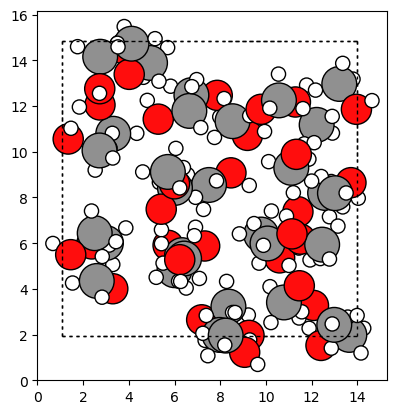

In [35]:
#構造可視化(matplotlib版)
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import ase.io
mol1 = ase.io.read('eq.gro')
%matplotlib inline
plot_atoms(mol1, rotation=('0x,0y,0z'))
plt.show()

In [33]:
#構造可視化(nglview版)
import nglview as nv
import ase.io
mol1 = ase.io.read('eq.gro')
w = nv.show_asetraj(mol1)
w.add_label(radius=1,color="black",label_type="atom")
w.add_unitcell()
w.update_unitcell()
w

AttributeError: 'Atom' object has no attribute 'write'

In [34]:
import nglview as nv

In [19]:
#Trajectoryの表示
import sys
import mdtraj

# ParmEd Imports
from parmed import load_file
from parmed.openmm.reporters import NetCDFReporter
from parmed import unit as u

#analysis
import os  
import subprocess
from subprocess import PIPE

!echo "System" > ./inputs/anal.txt 

commands = gromacs_home+"gmx trjconv -s eq.tpr -f eq.trr -dump 0 -o eq.pdb < ./inputs/anal.txt"
proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
output = proc.stdout
commands = gromacs_home+"gmx trjconv -s eq.tpr -f eq.trr -pbc mol -force -o eq_pbc.trr < ./inputs/anal.txt"
proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
output = proc.stdout


NGLWidget(max_frame=5000)

In [95]:
import mdtraj
traj=mdtraj.load("eq_pbc.trr", top="eq.pdb")
view=nv.show_mdtraj(traj,gui=True)
view.parameters =dict(
                        camera_type="orthographic",
                        backgraound_color="black",
                        clip_dist=0
)
view.clear_representations()
view.add_representation("ball+stick")
#view.add_representation("spacefill",selection=[i for i in range(n_atoms,n_total_atoms)],opacity=0.1)
view.add_unitcell()
view.update_unitcell()
view

NGLWidget(max_frame=5000)

In [20]:
#前半のトラジェクトリーのカットする
traj = traj[1001:]
len(traj)

4000

## Make a movie (gif format)

In [22]:
from time import sleep
# to save time for this tutorial, we make a movie with only 50 frames
for frame in range(0, 200):
    # set frame to update coordinates
    view.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    sleep(0.5)
    view.download_image(filename='BENimage{}.png'.format(frame))
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(2.0)

In [30]:
import moviepy.editor as mpy

# In my case, my default download folder is /Users/haichit/Downloads/
template = './img/BENimage{}.png'

# get all (sorted) image files
imagefiles = [template.format(str(i)) for i in range(0, 200)]

In [31]:
# make a gif file

frame_per_second = 8
im = mpy.ImageSequenceClip(imagefiles, fps=frame_per_second)
im.write_gif('BEN_8.gif', fps=frame_per_second)


t:   0%|          | 0/200 [00:00<?, ?it/s, now=None]

MoviePy - Building file BEN_8.gif with imageio.


In [32]:
# display the gif in this notebook

from IPython import display

display.HTML("<img src='BEN_8.gif'></img>")

In [33]:
#トラジェクトリーをASEで読み込んでQuantumEspressoの入力ファイルを出力する
filename = "BEN8"
for i,snapshot in enumerate(traj) :
    snapshot.save_gro("temp.gro")
    atoms1 = ase.io.read('temp.gro') # ちゃんとAngstrom単位に変換されている！！
    atoms1.write("./output/"+filename+"_"+str(i)+".in",format="espresso-in")

In [35]:
traj[-1].save_gro("temp.gro")
atoms1 = ase.io.read('temp.gro')

In [40]:
# atoms1.get_chemical_symbols()
# atoms1.get_cell()
# atoms1.get_positions()

# sorted(atoms1.get_chemical_symbols())

## CPMD用に原子の順番を並び替える

### CPMDでは原子種ごとに並べる必要がある．

In [96]:
# temp.groを読み込み
import ase.io
atoms1 = ase.io.read('temp.gro')

tmp=atoms1.get_chemical_symbols()
tmp2=atoms1.get_positions()/12.9116  # 分極座標を取得する

# get_cellを実行
print(atoms1.get_cell())

print(" tmp :: atoms1.get_chemical_symbols()")
print( tmp)

Cell([12.9116, 12.9116, 12.9116])
 tmp :: atoms1.get_chemical_symbols()
['C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H', 'H', 'H

In [102]:

# まず，原子種と座標を持ったリストanswerを作成
answer=[]

for i in range(len(tmp)):
    answer.append([tmp[i], tmp2[i][0],tmp2[i][1],tmp2[i][2] ])

# answerを原子種でソート
answer2 = sorted(answer, key=lambda x:x[0])

print(" ソート後の原子")
print([i[0] for i in answer2])


 ソート後の原子
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [130]:
# 一方で，後で機械学習をするために配列のインデックスを取得して，逆変換を行えるようにする．
# sortedでは，ソートするkeyが同じ値だった場合，他の最初の要素の順序を保つようにソートする（stableという性質らしい．https://docs.python.org/ja/3/howto/sorting.html 参照．）
# そこで，answerの後ろにインデックス用の番号を降るようにする．
import numpy as np

# ソート用のリストを作成
list=np.arange(len(answer))
list_for_sort=[[i[0],i[1],i[2],i[3],j] for i,j in zip(answer,list)]

sort_index=[i[4] for i in sorted(list_for_sort, key=lambda x:x[0])]
print(sort_index)
np.savetxt("sort_index_1129.txt",np.array(sort_index))


[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 2, 3, 4, 5, 8, 9, 10, 11, 14, 15, 16, 17, 20, 21, 22, 23, 26, 27, 28, 29, 32, 33, 34, 35, 38, 39, 40, 41, 44, 45, 46, 47, 50, 51, 52, 53, 56, 57, 58, 59, 62, 63, 64, 65, 68, 69, 70, 71, 74, 75, 76, 77, 80, 81, 82, 83, 86, 87, 88, 89, 92, 93, 94, 95, 98, 99, 100, 101, 104, 105, 106, 107, 110, 111, 112, 113, 116, 117, 118, 119, 122, 123, 124, 125, 128, 129, 130, 131, 134, 135, 136, 137, 140, 141, 142, 143, 146, 147, 148, 149, 152, 153, 154, 155, 158, 159, 160, 161, 164, 165, 166, 167, 170, 171, 172, 173, 176, 177, 178, 179, 182, 183, 184, 185, 188, 189, 190, 191, 1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 73, 79, 85, 91, 97, 103, 109, 115, 121, 127, 133, 139, 145, 151, 157, 163, 169, 175, 181, 187]


In [104]:
# sort_listを使って，answer2からanswerを復元する
answer_atomslist=[]

atom_list=[i[0] for i in answer2 ]
coord_list=[[i[1],i[2],i[3]] for i in answer2 ]

# sort_indexとリストを結合
atom_sort_list=[[i,j] for i,j in zip(sort_index,atom_list)]
coord_sort_list=[[i,j] for i,j in zip(sort_index,coord_list)]
print("")
print(atom_sort_list)
print("")

# sort_indexに従って配列を並べ直す．
sorted_atom_list= [i[1] for i in sorted(atom_sort_list, key=lambda x:x[0])]
sorted_coord_list=[i[1] for i in sorted(coord_sort_list, key=lambda x:x[0])]
print(" ")
print(" 再ソートした結果")
print(sorted_atom_list)
# print(sorted_coord_list)



[[42, 'C'], [96, 'C'], [90, 'C'], [150, 'C'], [36, 'C'], [108, 'C'], [114, 'C'], [168, 'C'], [132, 'C'], [18, 'C'], [162, 'C'], [12, 'C'], [6, 'C'], [60, 'C'], [24, 'C'], [72, 'C'], [174, 'C'], [180, 'C'], [156, 'C'], [102, 'C'], [0, 'C'], [144, 'C'], [78, 'C'], [30, 'C'], [54, 'C'], [66, 'C'], [126, 'C'], [186, 'C'], [48, 'C'], [84, 'C'], [138, 'C'], [120, 'C'], [47, 'H'], [95, 'H'], [98, 'H'], [154, 'H'], [113, 'H'], [39, 'H'], [45, 'H'], [93, 'H'], [46, 'H'], [155, 'H'], [110, 'H'], [100, 'H'], [99, 'H'], [101, 'H'], [173, 'H'], [152, 'H'], [41, 'H'], [111, 'H'], [92, 'H'], [40, 'H'], [94, 'H'], [44, 'H'], [118, 'H'], [153, 'H'], [116, 'H'], [38, 'H'], [119, 'H'], [112, 'H'], [136, 'H'], [171, 'H'], [65, 'H'], [117, 'H'], [20, 'H'], [172, 'H'], [166, 'H'], [16, 'H'], [167, 'H'], [9, 'H'], [170, 'H'], [137, 'H'], [28, 'H'], [23, 'H'], [134, 'H'], [14, 'H'], [135, 'H'], [11, 'H'], [165, 'H'], [27, 'H'], [22, 'H'], [74, 'H'], [15, 'H'], [63, 'H'], [21, 'H'], [8, 'H'], [17, 'H'], [164,

In [118]:
# 並べ替えた後のanswer2[0]と対応しているのはanswerのどれか？
# 今までは，sort_index[0]と思っていたが，どうも違うのか？
print(answer2[0])
print(answer[42])


['C', 0.6753616902630194, 0.3438768239412622, 0.20988878218036494]
['C', 0.11152761857554447, 0.34852380804857647, 0.5475696273118745]


In [74]:
# 原子の要素を取り出す
atoms_symbol=sorted(set(tmp))

# シンボルごとのカウント
num_atom = {}

for symbol in atoms_symbol:
    print("原子種と原子数", symbol, tmp.count(symbol))
    # num_atom.update(symbol = tmp.count(symbol))
    num_atom[symbol] = tmp.count(symbol)


print("num_atom:: ", num_atom)
print("")

for i, ans in enumerate(answer2):
    if i == 0: # 1行目の例外処理
        print(ans[0])
        print(num_atom[ans[0]])
        print("{:.6f}  {:.6f}  {:.6f}".format(ans[1],ans[2],ans[3]))
    else:
        if prev != ans[0]:
            print("")
            print(ans[0])
            print(num_atom[ans[0]])
        print("{:.6f}  {:.6f}  {:.6f}".format(ans[1],ans[2],ans[3]))

    # 一つ前の原子を保存
    prev = ans[0]
    

C 32
H 128
O 32
num_atom {'C': 32, 'H': 128, 'O': 32}
C
32
0.675362  0.343877  0.209889
0.414356  0.262555  0.891446
0.407386  0.274172  0.595588
0.381827  0.223055  0.298956
0.439140  0.816320  0.089842
0.752811  0.113851  0.923201
0.149478  0.315220  0.089842
0.111528  0.348524  0.547570
0.923201  0.037950  0.494129
0.777595  0.570030  0.627343
0.432170  0.762880  0.625794
0.863565  0.715636  0.236996
0.498776  0.511943  0.094489
0.735772  0.798507  0.953406
0.925524  0.484061  0.347749
0.127792  0.628892  0.506521
0.118498  0.186654  0.779144
0.578550  0.728028  0.371759
0.174262  0.685430  0.083646
0.236222  0.990582  0.546795
0.974318  1.003749  0.166517
0.882152  0.309799  0.779919
0.359367  0.556089  0.841879
0.940240  0.854271  0.701695
0.697048  0.313671  0.535178
0.130116  0.946436  0.882927
0.564609  0.099910  0.118498
0.383376  0.501874  0.361690
0.298956  0.925524  0.274172
0.534403  0.003872  0.443012
0.555315  1.002200  0.793085
0.892221  0.484835  0.011617

H
128
0.6637

# CPMD用原子種ソートがうまくいっているかの確認．

In [94]:
# ソートがちゃんとできているかの実験


# まず，原子種と座標を持ったリストanswerを作成
answer=[]

answer.append(["C", 0,0,1])
answer.append(["H", 0,0,2])
answer.append(["O", 0,0,3])
answer.append(["C", 0,0,4])
answer.append(["O", 0,0,5])

print(" ソート前のanswer")
print(answer)
print(" ")

# answerを原子種でソート
answer2 = sorted(answer, key=lambda x:x[0])
print(" ソート後のanswer2")
print("answer2", answer2)
print(" ")
# 一方で，後で機械学習をするために配列のインデックスを取得して，逆変換を行えるようにする．
sort_index=[i[0] for i in sorted(enumerate(answer), key=lambda x:x[1])]
print(" ソートリスト")
print("sort_index", sort_index)
print(" ")

# sort_listを使って，answer2からanswerを復元する
answer_atomslist=[]

atom_list=[i[0] for i in answer2 ]
coord_list=[[i[1],i[2],i[3]] for i in answer2 ]

# sort_indexとリストを結合
atom_sort_list=[[i,j] for i,j in zip(sort_index,atom_list)]
coord_sort_list=[[i,j] for i,j in zip(sort_index,coord_list)]
print("")
print(atom_sort_list)
print("")

# sort_indexに従って配列を並べ直す．
sorted_atom_list= [i[1] for i in sorted(atom_sort_list, key=lambda x:x[0])]
sorted_coord_list=[i[1] for i in sorted(coord_sort_list, key=lambda x:x[0])]
print(" ")
print(" 再ソートした結果")
print(sorted_atom_list)
print(sorted_coord_list)



 ソート前のanswer
[['C', 0, 0, 1], ['H', 0, 0, 2], ['O', 0, 0, 3], ['C', 0, 0, 4], ['O', 0, 0, 5]]
 
 ソート後のanswer2
answer2 [['C', 0, 0, 1], ['C', 0, 0, 4], ['H', 0, 0, 2], ['O', 0, 0, 3], ['O', 0, 0, 5]]
 
 ソートリスト
sort_index [0, 3, 1, 2, 4]
 

[[0, 'C'], [3, 'C'], [1, 'H'], [2, 'O'], [4, 'O']]

 
 再ソートした結果
['C', 'H', 'O', 'C', 'O']
[[0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5]]


In [166]:
def parser_in(file):
    path = file 
    with open(path) as f:

        s = 0
        p = 0
        d = 0
        system_parm=[]
        cell_parm = []
        atomic_pos = []

        for s_line in f:          
            #extract &SYSTEM   
            if "SYSTEM" in s_line :
                s = 1
                #system_parm = []
            if (s == 1) and ("/" in s_line ) :
                s = 0 
            if s == 1 :
                system_parm.append(s_line.rstrip('\n'))    

            #extract CELL_PARAMETERS      
            if "CELL_PARAMETERS" in s_line :
                p = 1
                #cell_parm = []
            if (p == 1) and (len(s_line.split()) == 0 ) :
                p = 0 
            if p == 1 :
                cell_parm.append(s_line.rstrip('\n'))

            #extract ATOMIC_POSITIONS      
            if "ATOMIC_POSITIONS" in s_line :
                d = 1
                #atomic_pos = []
            if (d == 1) and (len(s_line.split()) == 0 ) :
                d = 0 
            if d == 1 :
                atomic_pos.append(s_line.rstrip('\n'))    
                
    return [system_parm,cell_parm,atomic_pos]

atom_species = [
    "ATOMIC_SPECIES",
    "C 12.011 C.pbe-n-rrkjus_psl.1.0.0.UPF",
    "H 1.008  H.pbe-rrkjus_psl.1.0.0.UPF",
]        
        

In [167]:
def generate_QE_inp(system_parm,cell_parm,atom_species,atomic_pos,name,nberry,efield):
    
    system_parm = system_parm
    cell_parm   = cell_parm
    atomic_pos  = atomic_pos
    name        = name 
    nberry      = nberry
    atom_species= atom_species
    efield      = efield
    
    path_w = str(name)+"_pw.in"
    
    cont_parm = [
        "&control",
        "calculation='scf'",
        "restart_mode='restart'",
        "prefix='{}'".format(str(name)),
        "lelfield=.true. ",
        "nberrycyc={} ".format(int(nberry)),
        "pseudo_dir='./pseudo'  ",
        "outdir='./out' ",
        "tprnfor=.true. ",
        "tstress=.true. ",
    ]

    system_parm.append("ecutwfc=50  ")
    system_parm.append("ecutrho=200  ")
    system_parm.append("nosym=.true. ")
    #system_parm.append("occupations='smearing' , ")
    #system_parm.append("smearing='gauss' , ")
    #system_parm.append("degauss=0.01 , ")

    elec_parm = [ "&electrons" , 
        #"diagonalization='david'", 
        #"conv_thr =  1.0d-8" ,
        #"mixing_beta = 0.5"  ,
        #"startingwfc='random' " , 
        "efield_cart(1)={}".format(efield[0]) , 
        "efield_cart(2)={}".format(efield[1]) ,
        "efield_cart(3)={}".format(efield[2]) , 
    ]


    with open(path_w, mode='w') as f:
        #control
        for s in cont_parm :
            f.write(s+"\n")
        f.write("/\n")
        #system
        for s in system_parm :
            f.write(s+"\n")
        f.write("/\n")
        #electrons
        for s in elec_parm :
            f.write(s+"\n")
        f.write("/\n")
        #atom_species
        for s in atom_species :
            f.write(s+"\n")
        f.write("\n")
        #k-points 
        f.write("K_POINTS {automatic}" +"\n")
        f.write("1 1 1 0 0 0 "+"\n")        
        f.write("\n")
        #cell
        for s in cell_parm :
            f.write(s+"\n")
        f.write("\n")
        #atomic pos
        for s in atomic_pos :
            f.write(s+"\n")


In [168]:
def execute_QE(name) :
    import os
    import subprocess
    from subprocess import PIPE
    name = name 
    input_file  = str(name)+"_pw.in"
    output_file = str(name)+"_pw.out"
    os.environ['OMP_NUM_THREADS'] = '6'    
    commands = "pw.x < {0} > {1} ".format(input_file,output_file)
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

In [169]:
def extract_dipole(file):
    path = file 
    with open(path) as f:

        s = 0
        #mu_cell_x = []
        #mu_cell_y = []
        #mu_cell_z = []  

        for s_line in f:          
            #extract &Dipole Momnet   
            if "Electronic Dipole on Cartesian axes" in s_line :
                s = 1
                i = 0
            if (s == 1) and (i > 4 ) :
                s = 0 
            if (s == 1) and (i < 4 ) :
                if i == 1  :
                    mu_cell_x = float(s_line.split()[1])
                if i == 2  :
                    mu_cell_y = float(s_line.split()[1])
                if i == 3  :
                    mu_cell_z = float(s_line.split()[1])
                i +=1
    return [mu_cell_x, mu_cell_y, mu_cell_z]


In [ ]:
"""
The electronic dipole D[0.a.u.] at 0 field is a small number in the
order of 1.0d-4.  After the third calculation the electronic dipole
D[0.001 a.u.] at 0.001 a.u. field is 0.9265.

The high-frequency dielectric constant eps_inf is then given by

eps_inf=4*pi*(D[0.001 a.u.]-D[0.0 a.u.])/(0.001 a.u. * Omega) + 1

where Omega is the volume of the unit cell (1054.9778 (a.u.)^3). 
We obtain:

eps_inf=12.04

(Compare: other DFT calculations, 12.7-13.1 , exp. 11.4 )
The result 12.14 is not fully converged with respect to the k-points grid
P.Umari and A. Pasquarello, PRB 68, 085114 (2003).

"""

In [170]:
#擬ポテンシャルの設定
atom_species = [
    "ATOMIC_SPECIES",
    "C 12.011 C.pbe-n-rrkjus_psl.1.0.0.UPF",
    "H 1.008  H.pbe-rrkjus_psl.1.0.0.UPF",
]  

Mu = []

#トラジェクトリーをASEで読み込んでQuantumEspressoの入力ファイルを出力する
import numpy as np
from tqdm import tqdm
filename = "BEN"
for i,snapshot in tqdm(enumerate(traj)) :
    ###generate QE file###
    path = filename+".in"
    traj[i].save_gro("temp.gro")
    atoms1 = ase.io.read('temp.gro')
    volume = atoms1.get_volume()/(5.29177210903e-1**3) #atomic unit
    atoms1.write(path,format="espresso-in")   
    system_parm,cell_parm,atomic_pos = parser_in(path)
    name = "BEN"
    nberry = 1 
    efield = [0.0, 0.0, 0.0 ]
    generate_QE_inp(system_parm,cell_parm,atom_species,atomic_pos,filename,nberry,efield)
    execute_QE(filename) 
    D_ix,D_iy,D_iz = extract_dipole(str(filename)+"_pw.out")
    D_ref = np.array([D_ix,D_iy,D_iz])
    print(D_ix,D_iy,D_iz)
    
    nberry = 1 
    efield = [0.001, 0.0, 0.0 ]
    generate_QE_inp(system_parm,cell_parm,atom_species,atomic_pos,filename,nberry,efield)
    execute_QE(filename) 
    D_fx,D_fy,D_fz = extract_dipole(str(filename)+"_pw.out")
    D_Ex = np.array([D_fx,D_fy,D_fz])
    Mu_x = 4.0 * np.pi * (D_Ex - D_ref)/(0.001 * volume) + 1 
    print(D_fx,D_fy,D_fz)
    
    nberry = 1 
    efield = [0.0, 0.001, 0.0 ]
    generate_QE_inp(system_parm,cell_parm,atom_species,atomic_pos,filename,nberry,efield)
    execute_QE(filename) 
    D_fx,D_fy,D_fz = extract_dipole(str(filename)+"_pw.out")
    D_Ey = np.array([D_fx,D_fy,D_fz])
    Mu_y = 4.0 * np.pi * (D_Ey - D_ref)/(0.001 * volume) + 1 
    print(D_fx,D_fy,D_fz)
    
    nberry = 1 
    efield = [0.0, 0.0, 0.001 ]
    generate_QE_inp(system_parm,cell_parm,atom_species,atomic_pos,filename,nberry,efield)
    execute_QE(filename) 
    D_fx,D_fy,D_fz = extract_dipole(str(filename)+"_pw.out")
    D_Ez = np.array([D_fx,D_fy,D_fz])
    Mu_z = 4.0 * np.pi * (D_Ez - D_ref)/(0.001 * volume) + 1 
    print(D_fx,D_fy,D_fz)
    
    M_tensor = np.vstack([Mu_x,Mu_y,Mu_z])
    Mu.append(M_tensor)


0it [00:00, ?it/s]

-1.0867007360347007 -1.8236002242611027 -11.693738753498845
-0.32279904730842934 -1.8152083105304528 -11.707408319311735
-1.0797221764381242 -1.120941271802796 -11.680002482577128



1it [14:43, 883.26s/it]

-1.09785303653412 -1.8096137055825334 -10.946336987766825
-1.0870487475224495 -1.8239150193592883 -11.69296477933432
-0.32282052484876106 -1.8152169925713393 -11.70734530480576
-1.0797223984932782 -1.120937753700868 -11.680003349861478



2it [30:08, 907.88s/it]

-1.0978534977418113 -1.8096127790197585 -10.946336621295805
-1.087048913176718 -1.8239149828303103 -11.692964872878633
-0.3228205272848061 -1.8152169811821064 -11.7073453099696
-1.0797223980685988 -1.1209377530554685 -11.680003350282007



3it [45:32, 915.34s/it]

-1.0978534978136933 -1.809612778771719 -10.94633662119898
-1.0870489132016783 -1.8239149828191692 -11.6929648728904


3it [49:53, 997.84s/it]


KeyboardInterrupt: 